# DQN Dyad Experiments

In [3]:
import gym
import sys, time
import numpy as np; 
from numpy import asarray as narr
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
from torch import nn, optim

In [4]:
# Import custom scripts

sys.path.append('agents/')
sys.path.append('lib/')
import env_old
from lib import buffers, nn_models, torch_trainer
from agents import rl_agent, train_agents, benchmark_agents

In [5]:
import importlib
importlib.reload(env_old)

NameError: name 'env_old' is not defined

In [5]:
def benchmark(algo, hp, env, agent1, agent2, xaxis_params):
    # Creates time series for algorithm quality across episodes
    
    dyad_eval = benchmark_agents.dyad_eval
    
    t0 = time.time()
    
    # Unzip arguments
    n_episodes, n_intervals, n_eval = xaxis_params
    int_episodes=int(n_episodes/n_intervals)
    
    x, y = np.zeros(n_intervals+1), np.zeros(n_intervals+1)

    x[0] = 0
    y[0] = dyad_eval(env, agent1, agent2, n_episodes=1, normalizer=True)
    
    # Evaluate the created policy once every int_episodes episodes
    for i in range(n_intervals):
        print('Episode ', i*int_episodes, ': loss= ', y[i])
        
        for j in range(int_episodes):
            agent1, agent2 = algo(env, agent1, agent2)
            if i*int_episodes+j % hp.target_int == 0:
                agent1.update_target_qnet()
            elif i*int_episodes+j % hp.target_int == 1:
                agent2.update_target_qnet()
            
        x[i+1] = (i+1)*int_episodes
        y[i+1] = dyad_eval(env, agent1, agent2, n_episodes=n_eval, normalizer=True)
        
        ct = time.time()
        estimated_time_left = (n_intervals-i)*(ct-t0)/(i+1)
        print('Estimated time left: ', estimated_time_left)
        
    print('Total Duration: ', (ct- t0)/60, ' Minutes')
    return x,y, agent1, agent2
        

/u/sheybani/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode  0 : loss=  -0.23308697091371347
Estimated time left:  121.97449731826782
Episode  5 : loss=  -0.20500305021253473
Estimated time left:  59.81451463699341
Total Duration:  1.993817154566447  Minutes


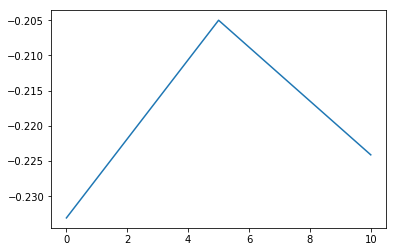

In [6]:
# Main

#------- Training hyperparams
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 10 #recommended: 100
n_intervals = 2
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 2000

# Algo hyperparams
learning_rate=0.001
batch_size=128
target_int = 2
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)

pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_f1, y_f1, agent1_f1, agent2_f1 = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_f1, y_f1)

In [7]:
agent1, agent2 = agent1_f1, agent2_f1
t_ts, rx_ts, forces_ts, qvals_ts, rewards = benchmark_agents.policy_ts(env, agent1, agent2) 

role1 = narr(qvals_ts[1])-narr(qvals_ts[0]) >0
role2 = narr(qvals_ts[3])-narr(qvals_ts[2]) >0

Env Reward =  -0.22319172169611942  Agent1 Mean Utility =  -0.22300557347118555  Agent2 Mean Utility =  -0.22300557347118555


Text(0.5, 0, 'Time Steps')

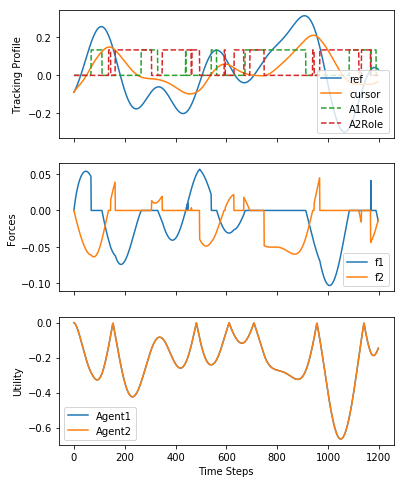

In [31]:
print('Env Reward = ', rewards[2], ' Agent1 Mean Utility = ', rewards[3], ' Agent2 Mean Utility = ', rewards[4])
fig,ax = plt.subplots(3, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role1*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A1Role');
ax[0].plot(t_ts, role2*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A2Role');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
_=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1].set_xlabel('Time Steps')